# Search Neighborhoods and Hotels

---
## Importing

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from geopy import Nominatim

import urllib.request
import json
from pandas import json_normalize

import folium

import time

In [2]:
nomi_obj = Nominatim(user_agent='Coursera_Student')

In [3]:
pd.set_option('display.max_rows', 500)

---
# Defining functions

### Coords

In [4]:
def frame_coords(lst, col_name='venue'):
    coords = []
    fail_list = []
    
    cnt = 0
    for item in lst:
        
        cnt2 = 0
        try:
            location = None
            while (location==None) and (cnt2<5):
                location = nomi_obj.geocode(item)
                cnt2+=1
                        
            if location!=None: coords.append((item, location[1][0], location[1][1]))
            else: 
                fail_list.append(item)
                print('Fail:', item)
                
            cnt = cnt+1
            if cnt in range(1, 500, 8): print('Appended:', len(coords), 'Attempts:', cnt)
        except: print(nomi_obj.geocode(item), location)
            
    print('Fail List: ', fail_list) 
    print('Completed')
    return pd.DataFrame(coords, columns=[col_name, 'lat', 'lng'])

### Mapping Functions

In [5]:
def plot_map(df, zoom=10):
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start = zoom)


    for lat, lng, label in zip(df['lat'], df['lng'], df.iloc[:, 0]):
    
        label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            popup=label,
                            radius=3,
                            color='darkorange',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [6]:
def plot_map_lite(df, zoom=11):
    
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=2,
                            color='darkred',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [7]:
def plot_search_map(df, zoom=11):
    
     
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label, radius in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values, df['radius'].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.Circle([lat, lng],
                      #popup=label,
                      radius=radius,
                      color='darkred',
                      #fill=True,
                      #fill_color='blue',
                      #fill_oppacity=0.8
                     ).add_to(mapa)
    return mapa
    

### Foursquare Functions

#### Construct foursquare API url

In [8]:
def foursquare_url(query=False,
                   explore=False,
                   venue=False,
                   ctgr_search=False,
                   ctgr_explore=False,
                   search_query=None,
                   ctgr_id=None,
                   venue_id=None,
                   radius=1500,
                   LIMIT=800,
                   lat=-22.9719642,       # Rio de Janeiro Center Coords
                   lng=-43.1843432):

    CLIENT_ID = 'YBZLHWZRC4DJGEF2GVTRMDCQZBCZXDBC0ZXPAMHZFR0RF3BC' # your Foursquare ID
    CLIENT_SECRET = 'NXISZGNL4VVTR24LS2GE3ZVQ14URDHPP0S0UNJTC41CKFW4I' # your Foursquare Secret
    VERSION = '20200604'
    latitude=lat
    longitude=lng
    
    expl_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    query_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    venue_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    ctgr_expl_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&category_Id={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, ctgr_id)
    ctgr_srch_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, ctgr_id)
    
    if ctgr_explore: return ctgr_expl_url
    if ctgr_search: return ctgr_srch_url
    if query: return query_url
    if explore: return expl_url
    if venue: return venue_url

#### Choose endpoint and search around locations

In [9]:
def get_venues(df,
               radius = 1000,
               explore=False,
               query=False,
               ctgr_search=False,
               ctgr_explore=False, 
               ctgr_id=None,
               search_query=None
              ):
    
    if type(radius)==int: radius = [radius for i in range(len(df))]

    keeper_cols = [df.columns[0], 'venue.id', 'venue.name', 'venue.category_id', 'venue.category', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance']
    keeper_cols_ctgr = [df.columns[0], 'id', 'name', 'category_id', 'category', 'location.lat', 'location.lng', 'location.distance']
    rqst_fail = []
    append_fail = []
    cnt = 0
    
    if ctgr_search or query: hoods_expl = pd.DataFrame(columns=keeper_cols_ctgr)
    else: hoods_expl = pd.DataFrame(columns=keeper_cols)
    
    
    
    for name, lat, lng, radius in zip(df.iloc[:, 0], df['lat'], df['lng'], radius):
     
        try: rqst_txt = urllib.request.urlopen(foursquare_url(explore=explore,
                                                              query=query,
                                                              ctgr_search=ctgr_search,
                                                              ctgr_explore=ctgr_explore,
                                                              ctgr_id=ctgr_id,
                                                              search_query=search_query,
                                                              lat=lat, 
                                                              lng=lng,
                                                              radius=radius)).read().decode()[:]
        except: 
            try: rqst_txt = urllib.request.urlopen(foursquare_url(explore=True,     # Maybe this will only run whenexplore=True, in other words try above will fail if explore=True
                                                                  lat=lat, 
                                                                  lng=lng,
                                                                  radius=radius)).read().decode()[:]
            except:
                print(name)
                rqst_fail.append(name)
                continue

        
        if (not ctgr_search) and (not query): rqst_df = json_normalize(json.loads(rqst_txt)['response']['groups'][0]['items'])  
        
        else: 
            try: rqst_df = json_normalize(json.loads(rqst_txt)['response']['venues'])
            except: 
                append_fail.append(name)
                continue
        
        if len(rqst_df)==0: 
            append_fail.append(name)
            continue
        
        rqst_df[keeper_cols[0]] = [name for i in range(len(rqst_df))]
    
        if (not ctgr_search) and (not query):            
            if 'venue.categories' in rqst_df.columns:
                rqst_df['venue.category_id'] = [i[0]['id'] if i!=[] else np.nan for i in rqst_df['venue.categories']] 
                rqst_df['venue.category'] = [i[0]['name'] if i!=[] else np.nan for i in rqst_df['venue.categories']]   
            else: 
                rqst_df['venue.category_id'] = [np.nan for i in range(len(rqst_df))]
                rqst_df['venue.category'] = [np.nan for i in range(len(rqst_df))]
                
            hoods_expl = pd.concat([hoods_expl, rqst_df[keeper_cols]], axis=0)
            
        else:
            if 'categories' in rqst_df.columns:
                rqst_df['category_id'] = [i[0]['id'] if i!=[] else np.nan for i in rqst_df['categories']] 
                rqst_df['category'] = [i[0]['name'] if i!=[] else np.nan for i in rqst_df['categories']]   
            else: 
                rqst_df['category_id'] = [np.nan for i in range(len(rqst_df))]
                rqst_df['category'] = [np.nan for i in range(len(rqst_df))]
                
            hoods_expl = pd.concat([hoods_expl, rqst_df[keeper_cols_ctgr]], axis=0)
        
        
        cnt+=1
        if cnt in range(0, len(df), 10): print('appended:', cnt, 'rqst_fail:', len(rqst_fail), 'append_fail:', len(append_fail))
    
    print('Searched:', len(df), 'Failed:', len(append_fail)+len(rqst_fail))
    print('Fail list: ', append_fail)
    print('Completed')
    return hoods_expl.reset_index(drop=True)


#### Search Multiple Categories

In [10]:
def get_ctgr_venues(df, radius=500, only=list(range(9))):

    ctgrs_txt = {'Food':'4d4b7105d754a06374d81259', 'Nightlife spots':'4d4b7105d754a06376d81259', 'Outdoors & Recreation':'4d4b7105d754a06377d81259', 'Beach':'4bf58dd8d48988d1e2941735', 'Shop e Services':'4d4b7105d754a06378d81259', 'Hotel':'4bf58dd8d48988d1fa931735', 'Travel and transport':'4d4b7105d754a06379d81259', 'Event': '4d4b7105d754a06373d81259', 'Arts & Entertainment':'4d4b7104d754a06370d81259'}
    ctgrs = pd.DataFrame(ctgrs_txt, index = ['ctgr_id']).T.reset_index().rename(columns={'index':'ctgr_name'})
    ctgrs = ctgrs[ctgrs.index.isin(only)]
    
    for ctgr_id, ctgr_name in zip(ctgrs['ctgr_id'], ctgrs['ctgr_name']):
    
        if ctgr_id==ctgrs['ctgr_id'].values[0]: 
        
            ctgrs_df = get_venues(df, ctgr_search=True, ctgr_id=ctgr_id, radius=radius)
    
            ctgrs_df['parent.category'] = [ctgr_name for i in range(len(ctgrs_df))]
        
        else:
        
            ctgr_df = get_venues(df, ctgr_search=True, ctgr_id=ctgr_id, radius=radius)
        
            ctgr_df['parent.category'] = [ctgr_name for i in range(len(ctgr_df))]
        
            ctgrs_df = pd.concat([ctgrs_df, ctgr_df], axis=0)
    
    
    return ctgrs_df

#### Venue Details

In [11]:
def get_details(df):

    extra = ['hereNow.count', 'hereNow.summary']
    keeper_cols = [#'venue_name',
                   'id',
                   'name',
                   'rating',
                   'likes.count',
                   'attributes.groups']+extra

    expl_ids = pd.DataFrame(columns=keeper_cols)
    fail_list = []
    cnt=0

    for venue, venue_id in zip(df.iloc[:, 1], df.iloc[:, 0]):
    
        if cnt in range(1, len(df), 240): time.sleep(4)
    
        try: rqst_txt = urllib.request.urlopen(foursquare_url(venue=True, venue_id=venue_id)).read().decode()[:]                
        
        except:
            try: rqst_txt = urllib.request.urlopen(foursquare_url(venue=True, venue_id=venue_id)).read().decode()[:]   
         
            except:
                try: rqst_txt = urllib.request.urlopen(foursquare_url(venue=True, venue_id=venue_id)).read().decode()[:]   
                
                except: 
                    row = pd.DataFrame([venue, venue_id]+[np.nan for i in range(len(keeper_cols)-2)]).T
                    expl_ids = pd.concat([expl_ids, row], axis=0)
                    fail_list.append([venue, venue_id])
                    print('fail:', venue, venue_id)
                    continue
                    
        rqst_json = json.loads(rqst_txt)['response']['venue']
                   
        rqst_row = json_normalize(json.loads(rqst_txt)['response']['venue'])       
        #rqst_row['venue_name'] = venue
        rqst_row['attributes.groups'][0] = ([i['name'] for i in rqst_row['attributes.groups'][0]])
        
        if 'rating' not in rqst_row.columns: rqst_row['rating']=[np.nan]
        if 'likes.count' not in rqst_row.columns: rqst_row['likes.count']=[np.nan]
                    
        row = rqst_row[keeper_cols]        
        expl_ids = pd.concat([expl_ids, row], axis=0)       
        
        cnt+=1
        if cnt in range(0,len(df), 30): print('Appended:', len(expl_ids), 'Searched:', cnt )
                
    return expl_ids

# Categories for search:
0. Food: 4d4b7105d754a06374d81259
1. Nightlife spots: 4d4b7105d754a06376d81259
2. Outdoors & Recreation: 4d4b7105d754a06377d81259
3. Beach: 4bf58dd8d48988d1e2941735
4. Shop e Services: 4d4b7105d754a06378d81259
5. Hotel: 4bf58dd8d48988d1fa931735
6. Travel and transport: 4d4b7105d754a06379d81259
7. Event: 4d4b7105d754a06373d81259
8. Arts & Entertainment: 4d4b7104d754a06370d81259
---

# Input: Loading Neighborhoods Coords

In [16]:
hoods = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\Clean\\complete_bairros.csv').drop('Unnamed: 0', axis=1)

In [31]:
plot_search_map(hoods, zoom=4)

# Planning

---
#### Gather Data (Organized)

1. General search over: neighborhoods DONE 
    1. Result: one dataframe of venues.
2. General explore over: neighborhoods  DONE
    1. Result: one dataframe of venues.
3. Construct a loop to use get_venues function to do the following: DONE
    1. Search neighborhoods per category: you can append results per category together if you add a new column 'parent.category' 
    2. Result: one dataframe of venues.
4. Clean Hotels 
5. Repeat 1, 2 and 3 for Hotels
    
---

# NEIGHBORHOODS

# 1. General search over: neighborhoods

In [ ]:
hoods_search = get_venues(hoods, query=True, radius=hoods['radius'])

In [217]:
#hoods_search.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_search.csv')

In [87]:
hoods_search = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_search.csv')

# 2. General explore over: neighborhoods

In [ ]:
hoods_explore = get_venues(hoods, explore=True, radius=hoods['radius'])

### Saving/Loading  General Hoods Explore Result

In [81]:
#hoods_explore.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_explore.csv')

In [84]:
hoods_explore = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_explore.csv', index_col=0)

# 3. Category Search over: Neighborhoods

In [38]:
ctgrs_txt = {'Food':'4d4b7105d754a06374d81259', 'Nightlife spots':'4d4b7105d754a06376d81259', 'Outdoors & Recreation':'4d4b7105d754a06377d81259', 'Beach':'4bf58dd8d48988d1e2941735', 'Shop e Services':'4d4b7105d754a06378d81259', 'Hotel':'4bf58dd8d48988d1fa931735', 'Travel and transport':'4d4b7105d754a06379d81259', 'Event': '4d4b7105d754a06373d81259', 'Arts & Entertainment':'4d4b7104d754a06370d81259'}

ctgrs = pd.DataFrame(ctgrs_txt, index = ['ctgr_id']).T.reset_index().rename(columns={'index':'ctgr_name'})

In [ ]:
for ctgr_id, ctgr_name in zip(ctgrs['ctgr_id'], ctgrs['ctgr_name']):
    
    if ctgr_id==ctgrs['ctgr_id'].values[0]: 
        
        hoods_ctgrs = get_venues(hoods, ctgr_search=True, ctgr_id=ctgr_id, radius=hoods['radius'])
    
        hoods_ctgrs['parent.category'] = [ctgr_name for i in range(len(hoods_ctgrs))]
        
    else:
        
        ctgr_df = get_venues(hoods, ctgr_search=True, ctgr_id=ctgr_id, radius=hoods['radius'])
        
        ctgr_df['parent.category'] = [ctgr_name for i in range(len(ctgr_df))]
        
        hoods_ctgrs = pd.concat([hoods_ctgrs, ctgr_df], axis=0)
    

## Saving/Loading Neighborhoods Category Search

#hoods_ctgrs.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_ctgrs.csv')

In [35]:
hoods_ctgrs = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_ctgrs.csv', index_col = 0)

# 4. Exploratory Analysis

In [48]:
hotels = hoods_ctgrs[hoods_ctgrs['parent.category']=='Hotel']

In [ ]:
hotels.drop_duplicates(subset=['name'])['category'].value_counts(ascending=True).plot(kind='barh')

hoods_ctgrs.drop_duplicates(subset=['name'])['parent.category'].value_counts().head(30).plot(kind='barh', figsize=(14,9))
plt.title('Number of venues in search results', fontsize=15)
plt.show()

## Coordinates Variance Analysis

In [128]:
hotel_stats = hotels.groupby(['bairros']).agg([np.mean, np.std])

In [ ]:
hotel_stats['location.lng']['std'][hotel_stats['location.lng']['std']<1].plot(kind='hist', bins=100)

In [175]:
hotel_stats_ctgr = hotels.groupby(['bairros', 'category'], as_index=False).agg([np.mean, np.std]).reset_index()

In [176]:
hotel_stats_hotel = hotel_stats_ctgr[hotel_stats_ctgr['category']=='Hotel']

In [ ]:
hotel_stats_hotel['location.lng']['mean'].plot(kind='hist', bins=100)     # Add Sub Plot for lat mean and explanation

## Hotels Visualization 

### All Hotel Categories

In [ ]:
plot_map(hotels.drop_duplicates(subset=['name']).rename(columns={'location.lat':'lat', 'location.lng':'lng'}).iloc[:, 2:])

# HOTELS

In [195]:
hotel_clean = hotels.drop_duplicates(subset=['name', 'id']).rename(columns={'location.lat':'lat', 'location.lng':'lng', 'name':'hotel'}).iloc[:, 2:].reset_index(drop=True)

# 1. General Search Over: Hotels

In [ ]:
hotel_search = get_venues(hotel_clean, radius=500, query=True)

#### Yes! Successful Search, 100 venues per hotel.

### Saving/Loading General Search over Hotels

In [252]:
#hotel_search.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_search.csv')

In [120]:
hotel_search = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_search.csv', index_col=0)

# 2. General Explore over: Hotels

In [ ]:
hotel_explore = get_venues(hotel_clean, radius=500, explore=True)

In [284]:
hotel_expl_fail = ['Bed and Breakfast Leblon', 'Pousada Cantinho do Sossego', 'Pousada Natural Life']

### Saving/Loading General Explore over: Hotels

In [261]:
#hotel_explore.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_explore.csv')

In [264]:
hotel_explore = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_explore.csv', index_col=0)

# 3. Category Search over: Hotels

## Food:

In [ ]:
hotel_food = get_ctgr_venues(hotel_clean, only=[0])

#### Saving/Loading Food Category Search over Hotels

In [288]:
#hotel_food.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_food.csv')

In [190]:
hotel_food = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_food.csv', index_col=0)

## Nightlife Spots:

In [ ]:
hotel_night = get_ctgr_venues(hotel_clean, only=[1])

#### Saving/Loading Nightlife Category Search over Hotels

In [330]:
#hotel_night.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_night.csv')

In [144]:
hotel_night = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_night.csv', index_col=0)

## From 'Outdoors & Recreation' to 'Shop e Services':

In [ ]:
hotel_2to4 = get_ctgr_venues(hotel_clean, only=[2, 3, 4])

### Saving Loading hotel category search 2 to 4 

In [42]:
#hotel_2to4.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_2to4.csv', index=False)

In [43]:
hotel_2to4 = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_2to4.csv')

## From 'Hotel' to 'Arts & Entertainment'

In [ ]:
hotel_5on = get_ctgr_venues(hotel_clean, only=[5,6,7,8])

### Saving Loading hotel category search 5 on 

In [199]:
#hotel_5on.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_5on.csv', index=False)

In [200]:
hotel_5on = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_5on.csv')

## Combining Category Searches around hotels into single dataframe

In [201]:
hotel_ctgrs = pd.concat([hotel_food, hotel_night, hotel_2to4, hotel_5on], axis=0)

### Saving/Loading Complete Category Search of Hotels

In [202]:
#hotel_ctgrs.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_ctgrs.csv', index=False)

In [203]:
hotel_ctgrs = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_ctgrs.csv')

In [209]:
hoods_ctgrs.drop_duplicates(subset=['name', 'id'])

,bairros,id,name,category_id,category,location.lat,location.lng,location.distance,parent.category
0,abolição,5ab00b797918713b5d262fab,Fábrica de Bolo Vó Alzira,52e81612bcbc57f1066b7a0a,Pie Shop,-22.885513,-43.300110,77,Food
1,abolição,4d5dad65f7d7224b54652081,Crepe Lieto,4bf58dd8d48988d146941735,Deli / Bodega,-22.885457,-43.299354,93,Food
2,abolição,59a047b3d8fe7a08a3d117a5,Sorveteria Gelatto,4bf58dd8d48988d1c9941735,Ice Cream Shop,-22.885130,-43.299610,117,Food
3,abolição,56f0a0b8498e8cfec89e061c,Churrasquinho do Beleza,4bf58dd8d48988d1df931735,BBQ Joint,-22.885426,-43.300530,107,Food
4,abolição,5b4bbe83628c83002c01f8e9,"Padaria, Armazém & Bar da Abolição",4bf58dd8d48988d16a941735,Bakery,-22.885736,-43.299418,64,Food
...,...,...,...,...,...,...,...,...,...
4888,vista alegre,5082bd19e4b0d5064b0d527f,Madadanca,4bf58dd8d48988d134941735,Dance Studio,-22.828760,-43.317589,270,Arts & Entertainment
4889,vista alegre,5144ace8e4b0136aa78ff427,roda de samba do dynei,4bf58dd8d48988d1e5931735,Music Venue,-22.826941,-43.317018,356,Arts & Entertainment
4890,vista alegre,4de1af158877bcb686334f21,Lona Cultural João Bosco,4d4b7104d754a06370d81259,Arts & Entertainment,-22.832276,-43.312361,409,Arts & Entertainment
4893,vista alegre,4f04eaae2c5b4138beab2f58,Cazuza's Dungeon,4bf58dd8d48988d18e941735,Comedy Club,-22.831370,-43.317633,322,Arts & Entertainment


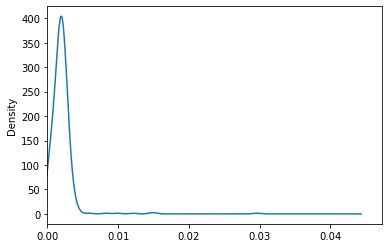

In [220]:
hotel_ctgrs.drop_duplicates(subset=['name', 'id']).groupby('hotel').std()['location.lat'].sort_values().plot(kind='kde', xlim=(0))

# 4. Hotels Details Search

In [53]:
hotel_ids450 = hotels.drop_duplicates(subset=['name', 'id']).rename(columns={'location.lat':'lat', 'location.lng':'lng', 'name':'hotel'}).iloc[:450, 1:3].reset_index(drop=True)

In [59]:
hotel_details450 = get_details(hotel_ids450)

<ipython-input-56-d7db0d28d5d5>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rqst_row['attributes.groups'][0] = ([i['name'] for i in rqst_row['attributes.groups'][0]])


Appended: 30 Searched: 30
Appended: 60 Searched: 60
Appended: 90 Searched: 90
Appended: 120 Searched: 120
Appended: 150 Searched: 150
Appended: 180 Searched: 180
Appended: 210 Searched: 210
Appended: 240 Searched: 240
Appended: 270 Searched: 270
Appended: 300 Searched: 300
Appended: 330 Searched: 330
Appended: 360 Searched: 360
Appended: 390 Searched: 390
Appended: 420 Searched: 420


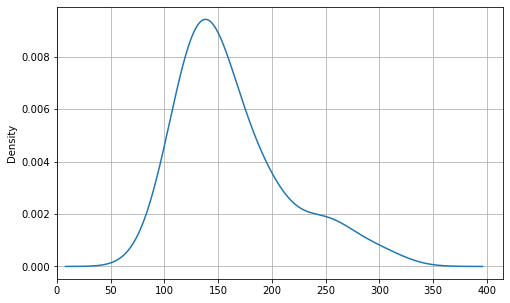

In [103]:
hotel_details450[(hotel_details450['likes.count']>100) & (hotel_details450['likes.count']<300)]['likes.count'].plot(kind='kde', xlim=(0), figsize=(8,5))

#plt.xticks(np.arange(0, 1000, 50))
plt.grid()

## Saving/Loading Hotel Details First half

In [60]:
#hotel_details450.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_details450.csv')

In [ ]:
hotel_details450 = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hotel_details450.csv')

# Nightlife Spots Clustering Analysis: K-means

In [486]:
night_hot_grp = pd.concat([hotel_night['hotel'], pd.get_dummies(hotel_night['category'])], axis=1).groupby('hotel').sum()

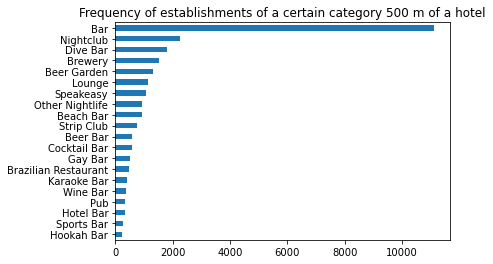

In [487]:
night_hot_grp.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.title('Frequency of establishments of a certain category 500 m of a hotel')
plt.show()

In [488]:
from sklearn.cluster import KMeans

In [489]:
x = night_hot_grp.copy()

In [490]:
inertias = []
for i in range(1, 40):
    
    kmeans = KMeans(n_clusters=i, n_init=12).fit(x)
    inertias.append((i,kmeans.inertia_))
    if i in range(1,200,3): print(i)

1
4
7
10
13
16
19
22
25
28
31
34
37


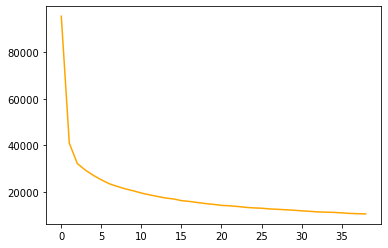

In [491]:
pd.DataFrame(inertias)[1].plot(color='orange')

In [504]:
kmeans = KMeans(n_clusters=3, n_init=12).fit(x.iloc[:, :-1])

In [505]:
x['label'] = kmeans.labels_

Text(0.5, 0, 'Proportion in 500 m sample around hotel')

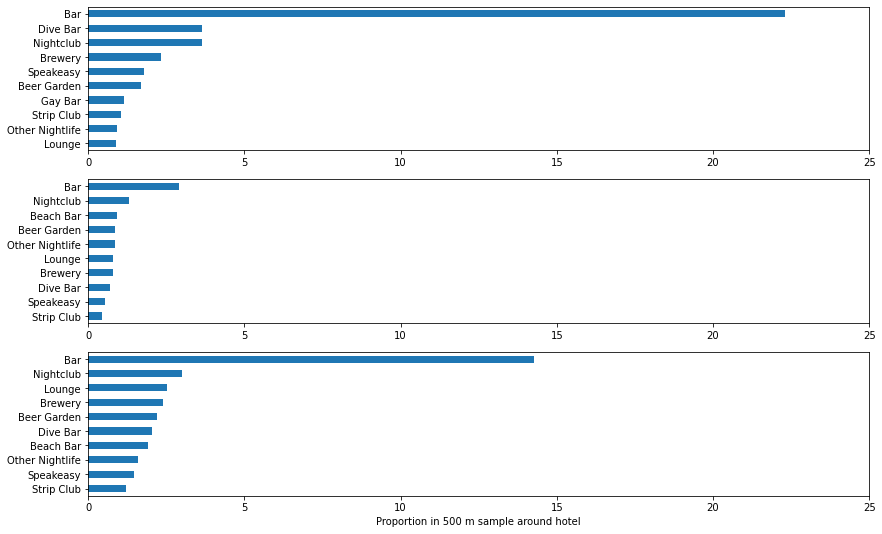

In [508]:
fig = plt.figure(figsize=(14,9))
ax0 = fig.add_subplot(3,1,1, xlim=(0,25))
ax1 = fig.add_subplot(3,1,2, xlim=(0,25))
ax2 = fig.add_subplot(3,1,3, xlim=(0,25))
#ax3 = fig.add_subplot(4,1,4, xlim=(0,25))
#ax4 = fig.add_subplot(6,1,5, xlim=(0,25))
#ax5 = fig.add_subplot(6,1,6, xlim=(0,25))


x[x['label']==0].iloc[:, :-1].mean().sort_values(ascending=True).tail(10).plot.barh(ax=ax0)
x[x['label']==1].iloc[:, :-1].mean().sort_values(ascending=True).tail(10).plot.barh(ax=ax1)
x[x['label']==2].iloc[:, :-1].mean().sort_values(ascending=True).tail(10).plot.barh(ax=ax2)
#x[x['label']==3].iloc[:, :-1].mean().sort_values(ascending=True).tail(10).plot.barh(ax=ax3)
#x[x['label']==4].iloc[:, :-1].mean().sort_values(ascending=True).tail(10).plot.barh(ax=ax4)
#x[x['label']==5].iloc[:, :-1].mean().sort_values(ascending=True).tail(10).plot.barh(ax=ax5)
plt.xlabel('Proportion in 500 m sample around hotel')

## 

# Food Analysis

In [300]:
food_hot = pd.get_dummies(hotel_food['category'])
food_hot_grp = pd.concat([food_hot, hotel_food['hotel']], axis=1).groupby('hotel').mean()

In [ ]:
food_hot_grp.mean().sort_values(ascending=True).tail(30).plot(kind='barh', figsize=(6,6))

# Hotel Details Analysis

In [155]:
from sklearn.preprocessing import StandardScaler as ss

In [179]:
hotel_hot_grp = pd.get_dummies(hotel_search['category'])
hotel_hot_grp['hotel'] = hotel_search['hotel']
x = hotel_hot_grp.groupby('hotel', sort=False).sum()
x_ss = pd.DataFrame(ss().fit_transform(x))
x_ss['hotel'] = x.index

In [180]:
hotel_info = pd.merge(hotel_clean, hotel_details450.rename(columns={'name':'hotel'}), on='hotel')

In [181]:
hotel_info = pd.merge(hotel_info, x_ss, on='hotel')

In [ ]:
hotel_info

In [183]:
hotel_info.corr()['rating'].sort_values(ascending=False)

rating    1.000000
211       0.221654
309       0.216680
269       0.209800
338       0.208730
            ...   
458            NaN
471            NaN
481            NaN
517            NaN
530            NaN
Name: rating, Length: 620, dtype: float64

In [191]:
night_hot_grp = pd.get_dummies(hotel_food['category'])
night_hot_grp['hotel'] = hotel_food['hotel']
x = night_hot_grp.groupby('hotel', sort=False).sum()
x_ss = pd.DataFrame(ss().fit_transform(x))
x_ss['hotel'] = x.index

In [192]:
night_info = pd.merge(hotel_clean, hotel_details450.rename(columns={'name':'hotel'}), on='hotel')

In [193]:
night_info = pd.merge(hotel_info, x_ss, on='hotel')

In [194]:
night_info.corr()['rating'].sort_values(ascending=False)

rating    1.000000
38_y      0.237515
211       0.221654
309       0.216680
269       0.209800
            ...   
127_y          NaN
140_y          NaN
144_y          NaN
147_y          NaN
157_y          NaN
Name: rating, Length: 780, dtype: float64